# 1.KNN estimator with a kernel funtion (20 pts)

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(2023)

## 1.1Generate data points

In [91]:
x_train = np.concatenate([np.random.normal(-20, 10, 20), np.random.normal(10, 5, 10)])
x_train = x_train.reshape((-1, 1))

x_test = np.linspace(np.min(x_train), np.max(x_train), 100)
x_test = x_test.reshape((-1, 1))

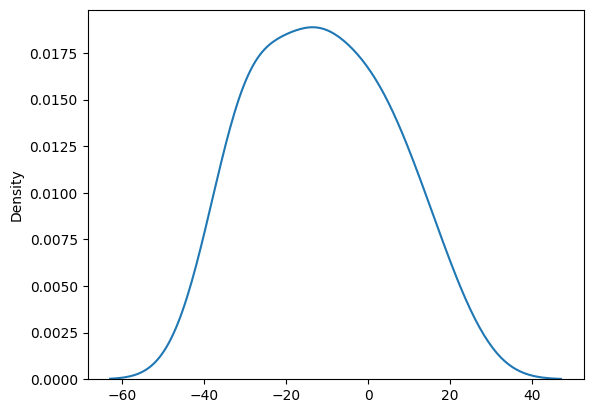

In [92]:
#  sampling  many dpoins for approximating the true distribution
# this is a multimodal density
sns.kdeplot(np.concatenate([np.random.normal(-20, 10, 20), np.random.normal(10, 5, 10)]))
plt.show()

## 1.2 Complete the code and draw the pictures
Completing KNN estimator wtih a kernel funtion. 
The kernel funtion is a Gaussian kernel, defined by $$K(u)=\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{u^2}{\tau}\right),$$
where $\tau$ is the length-scale. 

**Task:** You should complete the code for the KNN estimator with a Gaussian kernel function and plot the estimated density with three sets of parameters, as shown below
- $k=3,\tau=2$
- $k=3,\tau=0.2$
- $k=5,\tau=2$

**Hint:** We have already generated a set of test points and saved them in the variable x_test. Your task is to plot the estimated density function $\hat{p}(x)$ based on these points. The code framework has been provided, and you can either write it from scratch or fill in the missing parts in the framework.

In [93]:
# ##########################
# #Define your KNN estimator 
# #########################

class KNNKernelEstimator:
    def __init__(self, k, tau) -> None:
        self.k = k
        self.tau = tau
        self.p = None
    def gaussian_kernel(self, u):
        return (1 / np.sqrt(2 * np.pi)) * np.exp(-u ** 2 / self.tau)
    def fit(self, x_train):
        self.x = self.gaussian_kernel(x_train)
    def predict(self, x_test):
        p_hat = np.zeros(len(x_test))
        x_test = self.gaussian_kernel(x_test)
    # Loop over each test point
        for i in range(len(x_test)):
            # Compute the distance between the test point and each data point
            dist = np.abs(self.x - x_test[i])
            # Sort the distances and find the k nearest neighbors
            idx = np.argsort(dist)
            nn = self.x[idx[:self.k]]
            
            # Compute the weights for each neighbor using the Gaussian kernel function
            # weights = self.gaussian_kernel(dist[idx[:self.k]])
            weights = dist[idx[:self.k]]
            # Normalize the weights so that they sum up to one
            
            # Compute the estimated density value as the weighted average of the neighbors
            # print(weights)
            p_hat[i] = np.mean(weights) / np.sum(dist)
        
        # Return the estimated density values
        # print(p_hat)
        return p_hat


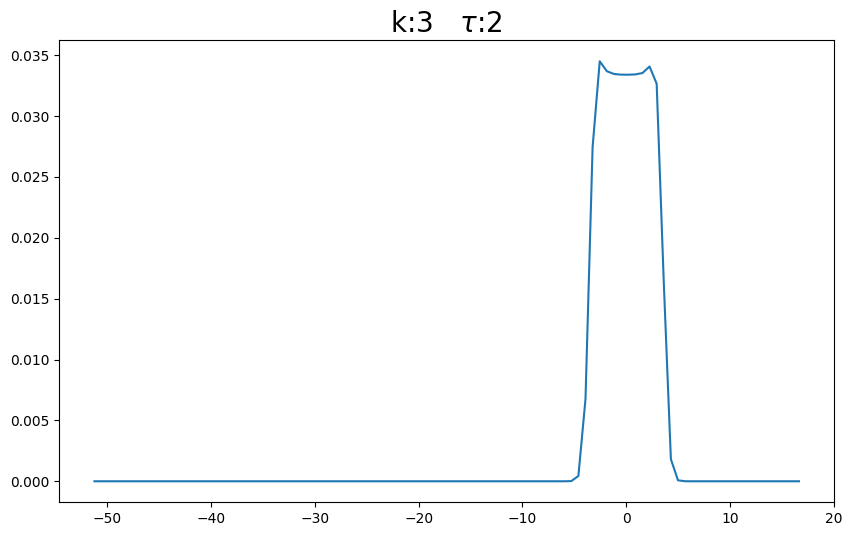

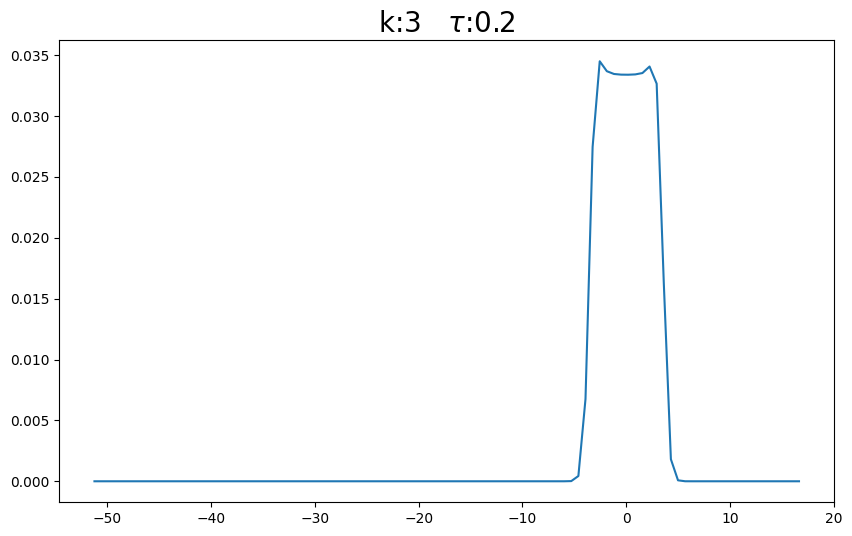

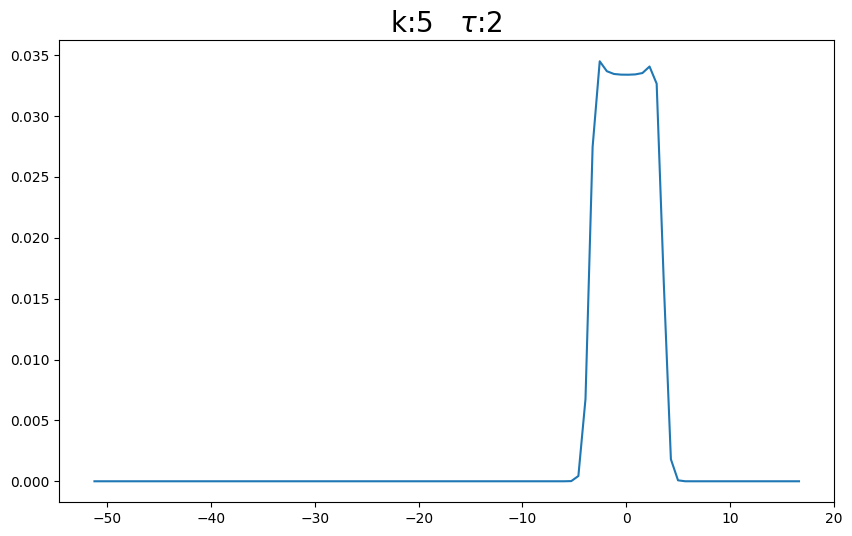

In [94]:
k = 3
tau = 2
##################
#Fill in the blanks by your code or using following template
kke = KNNKernelEstimator(k,tau)
kke.fit(x_train)
predict_x = kke.predict(x_test)
###################

plt.figure(figsize=(10, 6))
plt.plot(x_test, predict_x)
plt.title("k:" + str(k) + r"   $\tau$:" + str(tau), fontsize=20)
plt.show()

k = 3
tau = 0.2
##################
#Fill in the blanks by your code
###################
plt.figure(figsize=(10, 6))
plt.plot(x_test, predict_x)
plt.title("k:" + str(k) + r"   $\tau$:" + str(tau), fontsize=20)
plt.show()

k = 5
tau = 2
##################
#Fill in the blanks by your code
###################
plt.figure(figsize=(10, 6))
plt.plot(x_test, predict_x)
plt.title("k:" + str(k) + r"   $\tau$:"+str(tau), fontsize=20)
plt.show()

# 2.Deep Learning for classification (30 pts)

For this task, you are required to design and train a deep neural network to perform a classification task on a provided dataset. The dataset can be found at the following link: http://pan.shanghaitech.edu.cn/cloudservice/outerLink/decode?c3Vnb24xNjgyNzcwODk4OTU5c3Vnb24=

The dataset consists of a training set and test set. The training set should be used to train your model, and the test set should be used to evaluate the performance of your model.

**Your goal is to achieve at least 70% accuracy on the test set using your trained model. One point is deducted for every point the accuracy decreases**， such as 66.2% will lose 4 points.

If your computer does not have the necessary resources to train a deep neural network, you may use the computing resources of a school computing cluster, Kaggle, or Google Colab.

Hint:The use of pre-training models is prohibited (direct zero points) and custom neural networks are encouraged.



In [95]:
import os
import numpy as np
# !pip install opencv-python  # the command for installing opencv,i.e, cv2
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import time
import warnings
import  torch.nn.functional as F

warnings.filterwarnings("ignore")


In [96]:
# load the data set
def readfile(path, label):
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        x[i, :, :] = cv2.resize(img,(128, 128))
        if label:
            y[i] = int(file.split("_")[0])
    if label:
        return x, y
    else:
        return x

In [97]:
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
test_x, test_y = readfile(os.path.join(workspace_dir, "testing"), True)
print("Size of test data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of test data = 3430


In [98]:
transform_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

train_transform = transforms.Compose(transform_list)
test_transform = transforms.Compose(transform_list)

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [99]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = ImgDataset(test_x, test_y, test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 2.2 Construct deep learning model

In [100]:
################################
#Define your nerual network
##################################
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5) # input channel: 3 (RGB), output channel: 6, kernel size: 5
        self.conv2 = nn.Conv2d(6, 16, 5) # input channel: 6, output channel: 16, kernel size: 5
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 29 * 29, 120) # input size: 16 * 29 * 29 (after pooling), output size: 120
        self.fc2 = nn.Linear(120, 84) # input size: 120, output size: 84
        self.fc3 = nn.Linear(84, 10) # input size: 84, output size: 10 (number of classes)

    def forward(self, x):
        # Convolutional layer with ReLU activation and max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # pool size: (2, 2)
        # Convolutional layer with ReLU activation and max pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2)) # pool size: (2, 2)
        # Reshape the tensor to a vector for the fully connected layers
        x = x.view(-1, self.num_flat_features(x))
        # Fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Fully connected layer with ReLU activation
        x = F.relu(self.fc2(x))
        # Fully connected layer with softmax activation
        x = F.softmax(self.fc3(x), dim=1)
        return x

    def num_flat_features(self, x):
        # Get the size of each dimension except the batch dimension
        size = x.size()[1:]
        # Compute the number of features by multiplying all dimensions
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## 2.3 trianing your model
There are some tips which I hope can help you complete the task:
- If the loss function goes down too slowly, you can make the step size larger. This trick is better combined with an adaptive learning rate regulator
- If the model is overfitting, you can add a dropout layer in your model. 
-  [Data augmentation](https://pytorch.org/vision/stable/transforms.html) is also a good way to increase model generalization. We recommend that you do this.


In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5()
model.to(device)
loss = nn.CrossEntropyLoss(ignore_index=10)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
num_epoch = 100

# Create a ReduceLROnPlateau scheduler object
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model.train()
    for i, data in enumerate(train_loader):
        X_train, y_train = data
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()
        train_pred = model(X_train)
        batch_loss = loss(train_pred, y_train)
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss
    train_loss.backward()
    optimizer.step()

    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % (epoch + 1, num_epoch, time.time()-epoch_start_time, train_acc / train_set.__len__(), train_loss / train_set.__len__()))

[001/100] 19.57 sec(s) Train Acc: 0.049260 Loss: 0.018197
[002/100] 18.98 sec(s) Train Acc: 0.115954 Loss: 0.018192
[003/100] 19.01 sec(s) Train Acc: 0.151835 Loss: 0.018186
[004/100] 19.04 sec(s) Train Acc: 0.152443 Loss: 0.018178
[005/100] 18.95 sec(s) Train Acc: 0.154064 Loss: 0.018166
[006/100] 18.94 sec(s) Train Acc: 0.161160 Loss: 0.018151
[007/100] 18.82 sec(s) Train Acc: 0.188932 Loss: 0.018126
[008/100] 18.80 sec(s) Train Acc: 0.163288 Loss: 0.018076
[009/100] 19.02 sec(s) Train Acc: 0.152037 Loss: 0.017982
[010/100] 18.82 sec(s) Train Acc: 0.152037 Loss: 0.017909
[011/100] 18.82 sec(s) Train Acc: 0.152037 Loss: 0.018052
[012/100] 18.75 sec(s) Train Acc: 0.134300 Loss: 0.018303
[013/100] 18.92 sec(s) Train Acc: 0.134300 Loss: 0.018316
[014/100] 18.77 sec(s) Train Acc: 0.134300 Loss: 0.018308
[015/100] 18.60 sec(s) Train Acc: 0.134300 Loss: 0.018309
[016/100] 18.26 sec(s) Train Acc: 0.134300 Loss: 0.018316
[017/100] 18.48 sec(s) Train Acc: 0.134300 Loss: 0.018315
[018/100] 18.5

# Test your model
use your trained model to test the test set and print the accuracy.

In [102]:

model.eval()
test_acc = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        X_test, y_test = data
        X_test = X_test.to(device)
        test_pred = model(X_test)
        test_acc += np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())

test_acc = test_acc/test_set.__len__()
print("Test Acc: "+str(test_acc))

Test Acc: 0.13090379008746356
